In [51]:
%load_ext autoreload
%autoreload 2

import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sys.path.append('../')
from src.data_processor import DataProcessor

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
engine = DataProcessor(raw_data='../data/raw', processed_data='../data/processed/')
engine.load_data()


df_trans = engine.df_trans
df_prod = engine.df_prod
df_cust = engine.df_cust

tables = [
    ("Transactions", engine.df_trans),
    ("Products", engine.df_prod),
    ("Customers", engine.df_cust)
]

print(f"{'Table':<15} | {'Rows':<12} | {'Cols':<5} | {'Nulls %':<8}")
print("-" * 70)

for name, df in tables:
    rows = len(df)
    cols = len(df.columns)
    memory = df.memory_usage(deep=True).sum() / 1024**2
    null_pct = (df.isnull().sum().sum() / (rows * cols)) * 100
    print(f"{name:<15} | {rows:<12,} | {cols:<5} | {null_pct:<8.2f}%")
    


Data loaded successfully.
Table           | Rows         | Cols  | Nulls % 
----------------------------------------------------------------------
Transactions    | 1,983,549    | 9     | 0.00    %
Products        | 16,064       | 10    | 3.87    %
Customers       | 29,691       | 4     | 0.00    %


In [53]:
print("\n--- TRANSACTIONS DETAIL ---")
trans_audit = pd.DataFrame({
    'Dtype': engine.df_trans.dtypes,
    'Missing': engine.df_trans.isnull().sum(),
    'Unique': [engine.df_trans[col].nunique() for col in engine.df_trans.columns],
    'First_Value': engine.df_trans.iloc[0].values
})
print(trans_audit)


--- TRANSACTIONS DETAIL ---
                    Dtype  Missing   Unique              First_Value
id                  int64        0  1983549                  9974157
order_id            int64        0   262204                  1303020
trade_account_id    int64        0    27374                   635887
item_number        object        0    13721                  5008210
shipped_dt         object        0   220858  2025-01-16 12:21:00.000
origin             object        0        3                 EXTERNAL
type               object        0        2                   SAMPLE
netrevenue        float64        0     4912                      0.0
quantity          float64        0      577                      1.0


In [54]:
print("\n--- PRODUCT MASTER DETAIL ---")
prod_audit = pd.DataFrame({
    'Dtype': engine.df_prod.dtypes,
    'Missing': engine.df_prod.isnull().sum(),
    'Unique': [engine.df_prod[col].nunique() for col in engine.df_prod.columns],
    'First_Value': engine.df_prod.iloc[0].values
})
print(prod_audit)


--- PRODUCT MASTER DETAIL ---
                  Dtype  Missing  Unique              First_Value
item_number      object        0   16064                    54962
price_usd       float64      252     249                    158.0
arrival_date     object        0     346  2007-09-01 00:00:00.000
category_name    object        0       2                  FABRICS
color_name       object        3    2073                    IVORY
classification   object       22      13                    WOVEN
subclass         object      214      17              PLAIN WOVEN
scale            object       93       8                    SOLID
color_family     object     2887      46            WHITE & IVORY
motif            object     2747      41                    SOLID


In [55]:
print("\n--- CUSTOMER MASTER DETAIL ---")
cust_audit = pd.DataFrame({
    'Dtype': engine.df_cust.dtypes,
    'Missing': engine.df_cust.isnull().sum(),
    'Unique': [engine.df_cust[col].nunique() for col in engine.df_cust.columns],
    'First_Value': engine.df_cust.iloc[0].values
})
print(cust_audit)


--- CUSTOMER MASTER DETAIL ---
                   Dtype  Missing  Unique     First_Value
trade_account_id   int64        0   29691          670576
business_type     object        0      10   Design Studio
created_at        object        0    3418      2017-09-19
region            object        0      16  TRI-STATE AREA


In [56]:
print("=== KEY INTEGRITY CHECK ===")

# 1. Product Key Match
t_items = set(engine.df_trans['item_number'].unique())
p_items = set(engine.df_prod['item_number'].unique())
orphan_items = t_items - p_items

print(f"Total Unique Items in Transactions: {len(t_items):,}")
print(f"Total Unique Items in Product Master: {len(p_items):,}")
print(f"❌ ORPHAN ITEMS: {len(orphan_items):,} (Items sold but not in the Product Master)")

# 2. Customer Key Match
t_custs = set(engine.df_trans['trade_account_id'].unique())
c_custs = set(engine.df_cust['trade_account_id'].unique())
orphan_custs = t_custs - c_custs

print(f"\nTotal Unique Customers in Transactions: {len(t_custs):,}")
print(f"Total Unique Customers in Customer Master: {len(c_custs):,}")
print(f"❌ ORPHAN CUSTOMERS: {len(orphan_custs):,} (Accounts in Trans but not in the Customer Master)")

=== KEY INTEGRITY CHECK ===
Total Unique Items in Transactions: 13,721
Total Unique Items in Product Master: 16,064
❌ ORPHAN ITEMS: 0 (Items sold but not in the Product Master)

Total Unique Customers in Transactions: 27,374
Total Unique Customers in Customer Master: 29,691
❌ ORPHAN CUSTOMERS: 0 (Accounts in Trans but not in the Customer Master)


In [57]:
# Check for leading/trailing spaces in Transactions
spaces_trans = engine.df_trans['item_number'].str.contains(r'^\s|\s$').sum()

# Check for leading/trailing spaces in Product Master
spaces_prod = engine.df_prod['item_number'].str.contains(r'^\s|\s$').sum()

print(f"Items with hidden spaces (Trans): {spaces_trans}")
print(f"Items with hidden spaces (Prod): {spaces_prod}")

# Check for Case Sensitivity (Are there lowercase letters?)
lower_trans = engine.df_trans['item_number'].str.contains(r'[a-z]').sum()
print(f"Items with lowercase letters: {lower_trans}")

Items with hidden spaces (Trans): 0
Items with hidden spaces (Prod): 0
Items with lowercase letters: 0


In [58]:
# Convert to Sets for Comparison
set_trans = set(engine.df_trans['item_number'].unique())
set_prod = set(engine.df_prod['item_number'].unique())

# Calculate Overlap
common = set_trans.intersection(set_prod)
only_in_trans = set_trans - set_prod
only_in_prod = set_prod - set_trans

print("=== ITEM NUMBER ALIGNMENT ===")
print(f"Total unique items in Transactions: {len(set_trans):,}")
print(f"Total unique items in Product Master: {len(set_prod):,}")
print(f"✅ Items that MATCH: {len(common):,}")
print(f"❌ Orphan Items (Sales with no Product info): {len(only_in_trans):,}")
print(f"⚠️ Unsold Inventory (Products with no Sales/Samples): {len(only_in_prod):,}")

# Calculate Match Percentage
match_rate = (len(common) / len(set_trans)) * 100
print(f"\nMatch Rate: {match_rate:.2f}%")

=== ITEM NUMBER ALIGNMENT ===
Total unique items in Transactions: 13,721
Total unique items in Product Master: 16,064
✅ Items that MATCH: 13,721
❌ Orphan Items (Sales with no Product info): 0
⚠️ Unsold Inventory (Products with no Sales/Samples): 2,343

Match Rate: 100.00%


In [59]:
engine.merge_data()
df = engine.df_master
print(f"Master Table Columns: {df.columns.tolist()}")

📦 Processed data found at ../data/processed/master_analytical_file.csv. Loading existing file...
✅ Loaded 1,983,549 records from disk.
Master Table Columns: ['id', 'order_id', 'trade_account_id', 'item_number', 'shipped_dt', 'origin', 'type', 'netrevenue', 'quantity', 'business_type', 'created_at', 'region', 'price_usd', 'arrival_date', 'category_name', 'color_name', 'classification', 'subclass', 'scale', 'color_family', 'motif']


In [60]:
df.head()

,id,order_id,trade_account_id,item_number,shipped_dt,origin,type,netrevenue,quantity,business_type,...,region,price_usd,arrival_date,category_name,color_name,classification,subclass,scale,color_family,motif
0,9974157,1303020,635887,5008210,2025-01-16 12:21:00.000,EXTERNAL,SAMPLE,0.0,1.0,Other,...,HEARTLAND,94.0,2016-09-05 00:00:00.000,WALLCOVERINGS,FOG,TEXTURE,PRINT,EXTRA LARGE,LIGHT NEUTRAL,PAISLEY
1,11033952,1420308,647987,5013651,2025-05-01 17:43:00.000,EXTERNAL,SAMPLE,0.0,2.0,At Home Decorators,...,MIDWEST,48.0,2022-03-07 00:00:00.000,WALLCOVERINGS,OFF BLACK,FLAT PAPER,PRINT,MEDIUM,LIGHT NEUTRAL,DOTS
2,10381241,1346080,653558,75683,2025-02-21 00:26:06.730,Showroom,SAMPLE,0.0,1.0,Design Studio,...,PACIFIC SOUTHWEST,118.0,2021-08-02 00:00:00.000,FABRICS,YELLOW,WOVEN,PLAIN WOVEN,SOLID,YELLOW,SOLID
3,9966140,1302139,689951,175160,2025-01-14 14:18:00.000,EXTERNAL,SAMPLE,0.0,1.0,Other,...,SOUTH,178.0,2012-08-15 00:00:00.000,FABRICS,TAN,PRINT,PRINTED,LARGE,LIGHT NEUTRAL,ANIMAL
4,11123734,1430077,725247,5010571,2025-05-12 12:45:41.000,EXTERNAL,PRODUCT,1160.0,20.0,Other,...,ROCKY MOUNTAINS,58.0,2020-02-03 00:00:00.000,WALLCOVERINGS,SMOKE,FLAT PAPER,PRINT,LARGE,LIGHT NEUTRAL,GEOMETRIC


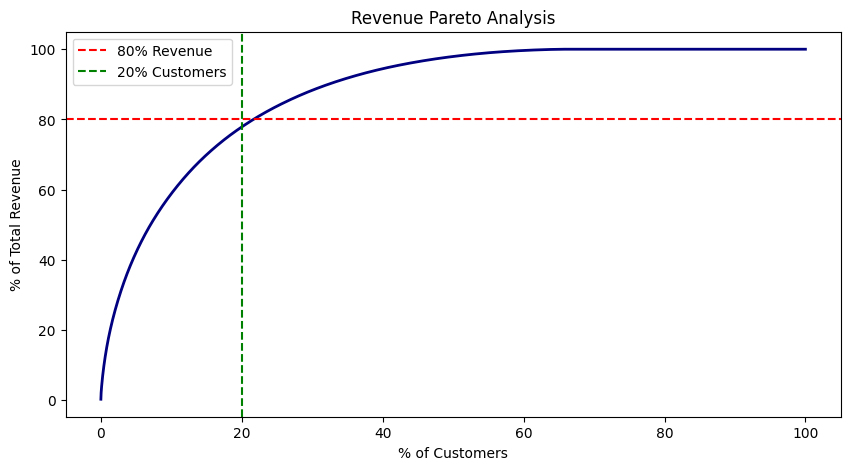

In [61]:
# Grouping by account to see total spend
customer_value = df.groupby('trade_account_id')['netrevenue'].sum().sort_values(ascending=False).reset_index()

# Calculated cumulative percentage
customer_value['cum_revenue_pct'] = 100 * (customer_value['netrevenue'].cumsum() / customer_value['netrevenue'].sum())
customer_value['cum_customer_pct'] = 100 * (customer_value.index + 1) / len(customer_value)


plt.figure(figsize=(10, 5))
plt.plot(customer_value['cum_customer_pct'], customer_value['cum_revenue_pct'], color='navy', lw=2)
plt.axhline(80, color='red', linestyle='--', label='80% Revenue')
plt.axvline(20, color='green', linestyle='--', label='20% Customers')
plt.title('Revenue Pareto Analysis')
plt.xlabel('% of Customers')
plt.ylabel('% of Total Revenue')
plt.legend()
plt.show()

In [ ]:
total_samples = df[df['type'] == 'SAMPLE'].groupby(['trade_account_id', 'item_number']).size().shape[0]

total_sales = df[df['type'] == 'SALE'].groupby(['trade_account_id', 'item_number']).size().shape[0]

conversion_rate = (total_sales / total_samples) * 100
print(f"Global Sample-to-Sale Conversion Rate: {conversion_rate:.2f}%")

Global Sample-to-Sale Conversion Rate: 0.00%


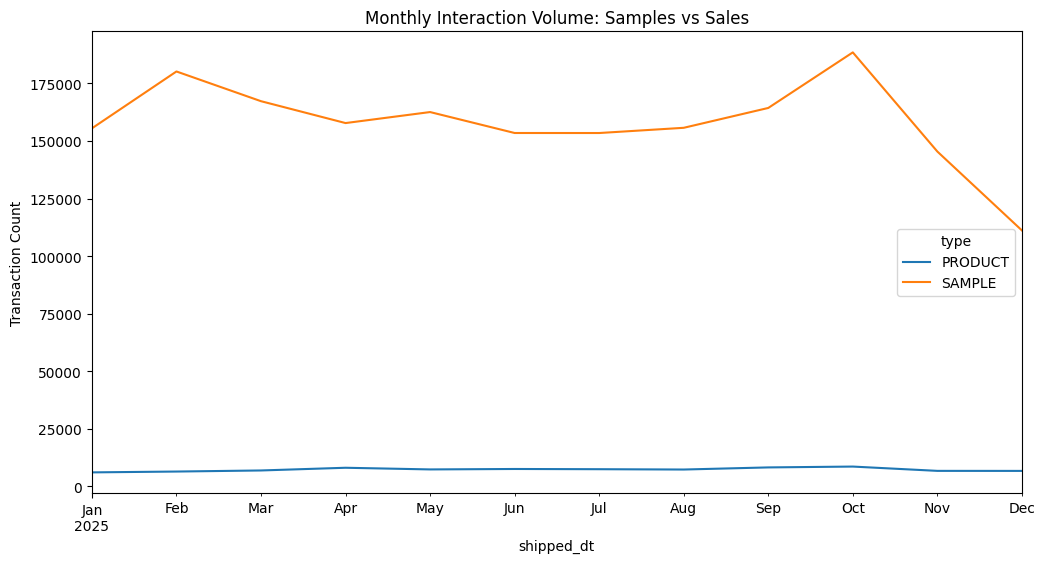

In [63]:
df['shipped_dt'] = pd.to_datetime(df['shipped_dt'])
df.set_index('shipped_dt').resample('ME')['type'].value_counts().unstack().plot(figsize=(12, 6))
plt.title('Monthly Interaction Volume: Samples vs Sales')
plt.ylabel('Transaction Count')
plt.show()



In [64]:
engine.df_trans['item_number'] = engine.df_trans['item_number'].astype(str).str.strip().str.upper()
engine.df_prod['item_number'] = engine.df_prod['item_number'].astype(str).str.strip().str.upper()

print("✅ Item Numbers sanitized (Stripped & Uppercased).")

✅ Item Numbers sanitized (Stripped & Uppercased).


In [65]:
# Create unique 'Keys' by combining Account and Item
sample_keys = set(df_trans[df_trans['type'] == 'SAMPLE']['trade_account_id'].astype(str) + "_" + df_trans[df_trans['type'] == 'SAMPLE']['item_number'].astype(str))
sale_keys = set(df_trans[df_trans['type'] == 'SALE']['trade_account_id'].astype(str) + "_" + df_trans[df_trans['type'] == 'SALE']['item_number'].astype(str))

intersection = sample_keys.intersection(sale_keys)

print(f"Total Unique Sample Journeys: {len(sample_keys):,}")
print(f"Total Unique Sale Journeys: {len(sale_keys):,}")
print(f"✅ OVERLAP FOUND: {len(intersection):,}")

if len(intersection) == 0:
    print("❌ CRITICAL: No customer who sampled an item ended up buying THAT EXACT item.")

Total Unique Sample Journeys: 1,740,892
Total Unique Sale Journeys: 0
✅ OVERLAP FOUND: 0
❌ CRITICAL: No customer who sampled an item ended up buying THAT EXACT item.


New Column Names: ['month', 'id_product', 'id_sample', 'netrevenue_product', 'netrevenue_sample']


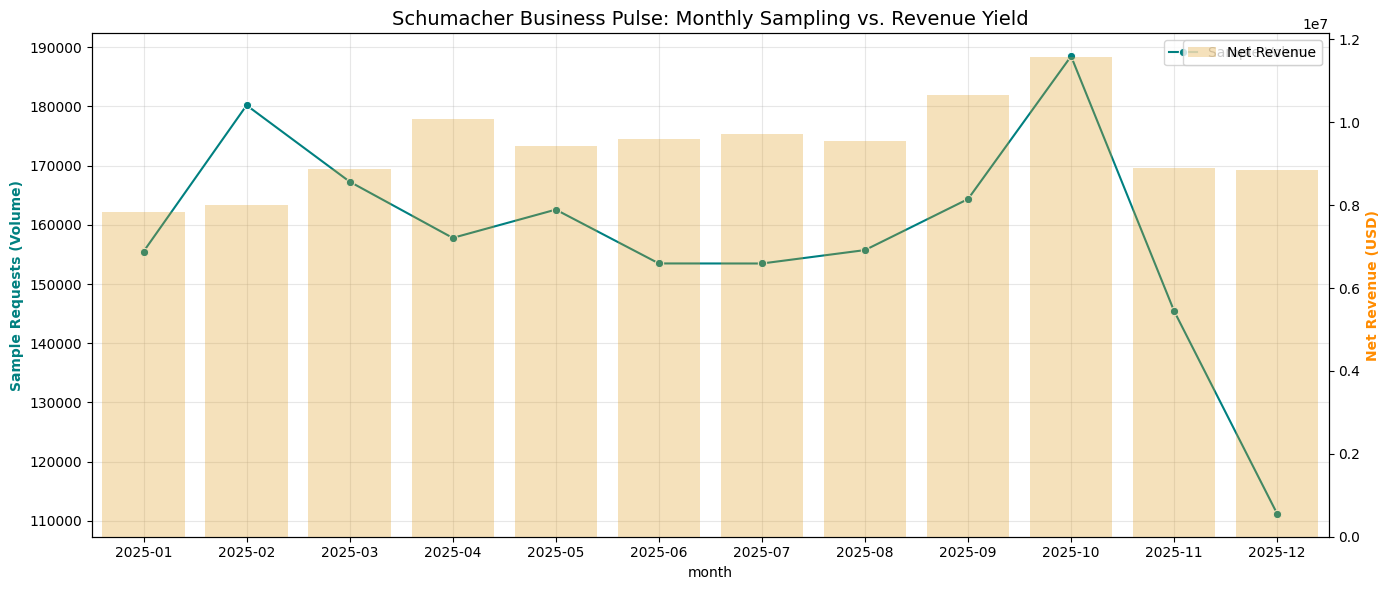

In [ ]:
df['month'] = df['shipped_dt'].dt.to_period('M').astype(str)

monthly = df.groupby(['month', 'type']).agg({
    'id': 'count', 
    'netrevenue': 'sum'
}).unstack(fill_value=0)

monthly.columns = [f"{col[0]}_{col[1]}".lower() for col in monthly.columns]
monthly = monthly.reset_index()

print("New Column Names:", monthly.columns.tolist())
fig, ax1 = plt.subplots(figsize=(14, 6))
ax2 = ax1.twinx()
sns.lineplot(data=monthly, x='month', y='id_sample', ax=ax1, color='teal', marker='o', label='Sample Volume')
sns.barplot(data=monthly, x='month', y='netrevenue_product', ax=ax2, color='orange', alpha=0.3, label='Net Revenue')
ax1.set_ylabel('Sample Requests (Volume)', color='teal', fontweight='bold')
ax2.set_ylabel('Net Revenue (USD)', color='darkorange', fontweight='bold')
plt.title('Schumacher Business Pulse: Monthly Sampling vs. Revenue Yield', fontsize=14)
plt.xticks(rotation=45)
ax1.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Median Days to Convert: 50.0 days


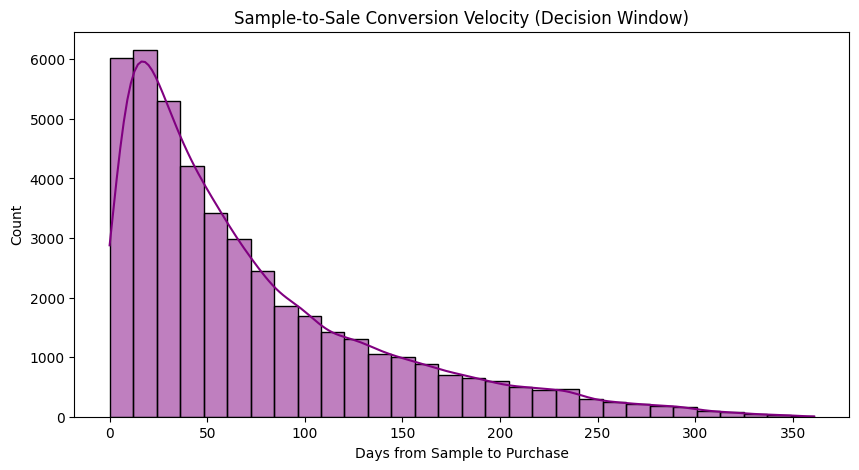

In [ ]:
samples_only = df[df['type'] == 'SAMPLE'][['trade_account_id', 'item_number', 'shipped_dt']].rename(columns={'shipped_dt': 'sample_date'})
sales_only = df[df['type'] == 'PRODUCT'][['trade_account_id', 'item_number', 'shipped_dt']].rename(columns={'shipped_dt': 'sale_date'})
conversions = pd.merge(samples_only, sales_only, on=['trade_account_id', 'item_number'], how='inner')

#Calculated Days to Convert
conversions['days_to_convert'] = (conversions['sale_date'] - conversions['sample_date']).dt.days
conversions = conversions[conversions['days_to_convert'] >= 0]

print(f"Median Days to Convert: {conversions['days_to_convert'].median()} days")
plt.figure(figsize=(10, 5))
sns.histplot(conversions['days_to_convert'], bins=30, kde=True, color='purple')
plt.title('Sample-to-Sale Conversion Velocity (Decision Window)')
plt.xlabel('Days from Sample to Purchase')
plt.show()

In [80]:
import plotly.express as px
samples_df = df[df['type'] == 'SAMPLE'].groupby(['trade_account_id', 'item_number'])['shipped_dt'].min().reset_index()
samples_df.columns = ['trade_account_id', 'item_number', 'first_sample_date']

sales_df = df[df['type'] == 'PRODUCT'].groupby(['trade_account_id', 'item_number'])['shipped_dt'].min().reset_index()
sales_df.columns = ['trade_account_id', 'item_number', 'first_sale_date']

conversion_journey = pd.merge(samples_df, sales_df, on=['trade_account_id', 'item_number'], how='inner')

conversion_journey = conversion_journey[conversion_journey['first_sale_date'] >= conversion_journey['first_sample_date']]

total_unique_samples = len(samples_df)
converted_samples = len(conversion_journey)
conversion_rate = (converted_samples / total_unique_samples) * 100 if total_unique_samples > 0 else 0

funnel_data = pd.DataFrame({
    'Stage': ['Unique Items Sampled', 'Matched Sales'],
    'Count': [total_unique_samples, converted_samples]
})

fig = px.funnel(
    funnel_data, 
    x='Count', 
    y='Stage', 
    title=f'Schumacher Conversion Strategy (Global CR: {conversion_rate:.2f}%)',
    color_discrete_sequence=['#2C3E50', '#E67E22']
)

fig.update_traces(textinfo='value+percent initial')
fig.show()

print(f"--- Strategic Insights ---")
print(f"Total Unique Sample Journeys: {total_unique_samples:,}")
print(f"Direct Match Conversions:    {converted_samples:,}")
print(f"Net Conversion Rate:         {conversion_rate:.2f}%")

--- Strategic Insights ---
Total Unique Sample Journeys: 1,740,892
Direct Match Conversions:    30,676
Net Conversion Rate:         1.76%


In [74]:
df.head()

,id,order_id,trade_account_id,item_number,shipped_dt,origin,type,netrevenue,quantity,business_type,...,price_usd,arrival_date,category_name,color_name,classification,subclass,scale,color_family,motif,month
0,9974157,1303020,635887,5008210,2025-01-16 12:21:00.000,EXTERNAL,SAMPLE,0.0,1.0,Other,...,94.0,2016-09-05 00:00:00.000,WALLCOVERINGS,FOG,TEXTURE,PRINT,EXTRA LARGE,LIGHT NEUTRAL,PAISLEY,2025-01
1,11033952,1420308,647987,5013651,2025-05-01 17:43:00.000,EXTERNAL,SAMPLE,0.0,2.0,At Home Decorators,...,48.0,2022-03-07 00:00:00.000,WALLCOVERINGS,OFF BLACK,FLAT PAPER,PRINT,MEDIUM,LIGHT NEUTRAL,DOTS,2025-05
2,10381241,1346080,653558,75683,2025-02-21 00:26:06.730,Showroom,SAMPLE,0.0,1.0,Design Studio,...,118.0,2021-08-02 00:00:00.000,FABRICS,YELLOW,WOVEN,PLAIN WOVEN,SOLID,YELLOW,SOLID,2025-02
3,9966140,1302139,689951,175160,2025-01-14 14:18:00.000,EXTERNAL,SAMPLE,0.0,1.0,Other,...,178.0,2012-08-15 00:00:00.000,FABRICS,TAN,PRINT,PRINTED,LARGE,LIGHT NEUTRAL,ANIMAL,2025-01
4,11123734,1430077,725247,5010571,2025-05-12 12:45:41.000,EXTERNAL,PRODUCT,1160.0,20.0,Other,...,58.0,2020-02-03 00:00:00.000,WALLCOVERINGS,SMOKE,FLAT PAPER,PRINT,LARGE,LIGHT NEUTRAL,GEOMETRIC,2025-05


C:\Users\P.Avinash\AppData\Local\Temp\ipykernel_28736\203808566.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




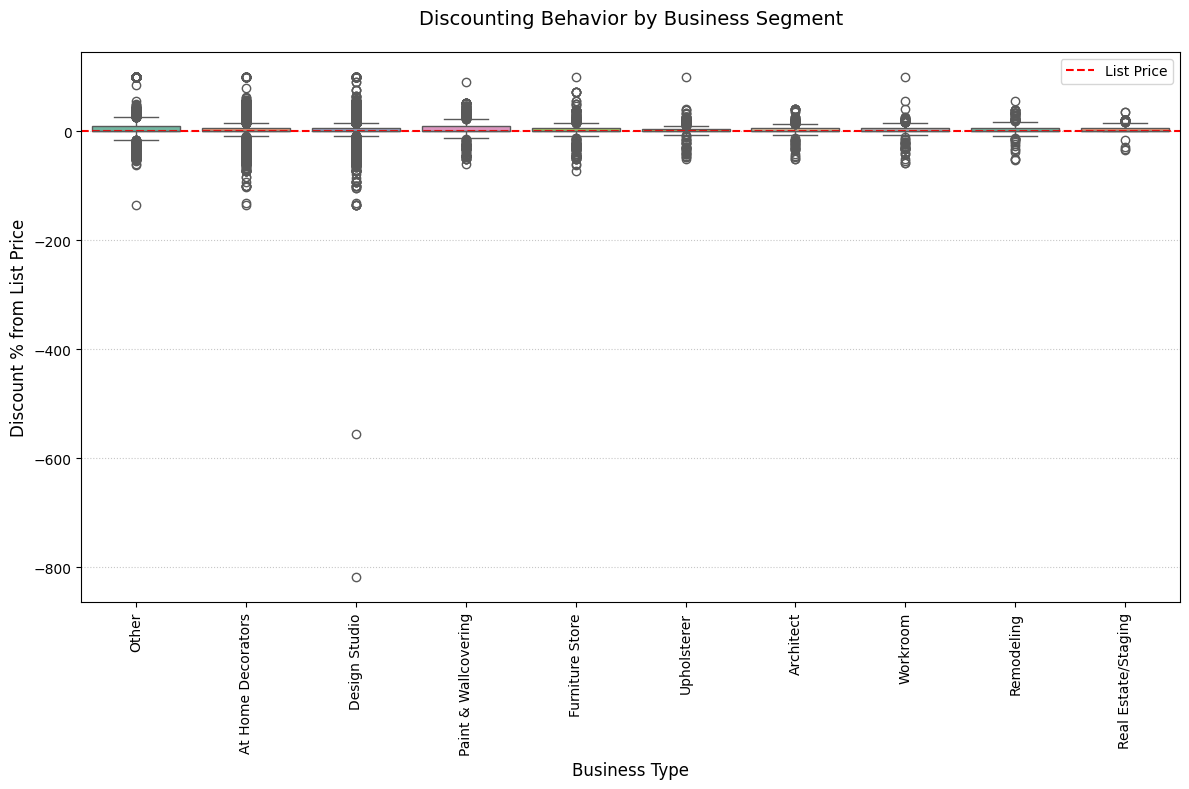

In [76]:
# 1. Calculate Unit Price in Transactions
# We filter for 'PRODUCT' type and quantity > 0 to avoid division by zero
df_sales = df[(df['type'] == 'PRODUCT') & (df['quantity'] > 0)].copy()
df_sales['realized_unit_price'] = df_sales['netrevenue'] / df_sales['quantity']
df_sales['discount_pct'] = (1 - (df_sales['realized_unit_price'] / df_sales['price_usd'])) * 100

# 2. Plotting with Vertical Labels
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_sales, x='business_type', y='discount_pct', palette='Set2')

# --- THE FIX: Vertical Labels ---
plt.xticks(rotation=90, ha='center', fontsize=10) 

# Adding a 'Zero Line' (List Price Reference)
plt.axhline(0, color='red', linestyle='--', linewidth=1.5, label='List Price')

# Clean up the visual
plt.title('Discounting Behavior by Business Segment', fontsize=14, pad=20)
plt.ylabel('Discount % from List Price', fontsize=12)
plt.xlabel('Business Type', fontsize=12)
plt.grid(axis='y', linestyle=':', alpha=0.7)
plt.legend()

plt.tight_layout() # Ensures labels don't get cut off at the bottom
plt.show()

C:\Users\P.Avinash\AppData\Local\Temp\ipykernel_28736\3509441311.py:13: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\P.Avinash\AppData\Local\Temp\ipykernel_28736\3509441311.py:14: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\P.Avinash\AppData\Local\Temp\ipykernel_28736\3509441311.py:22: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




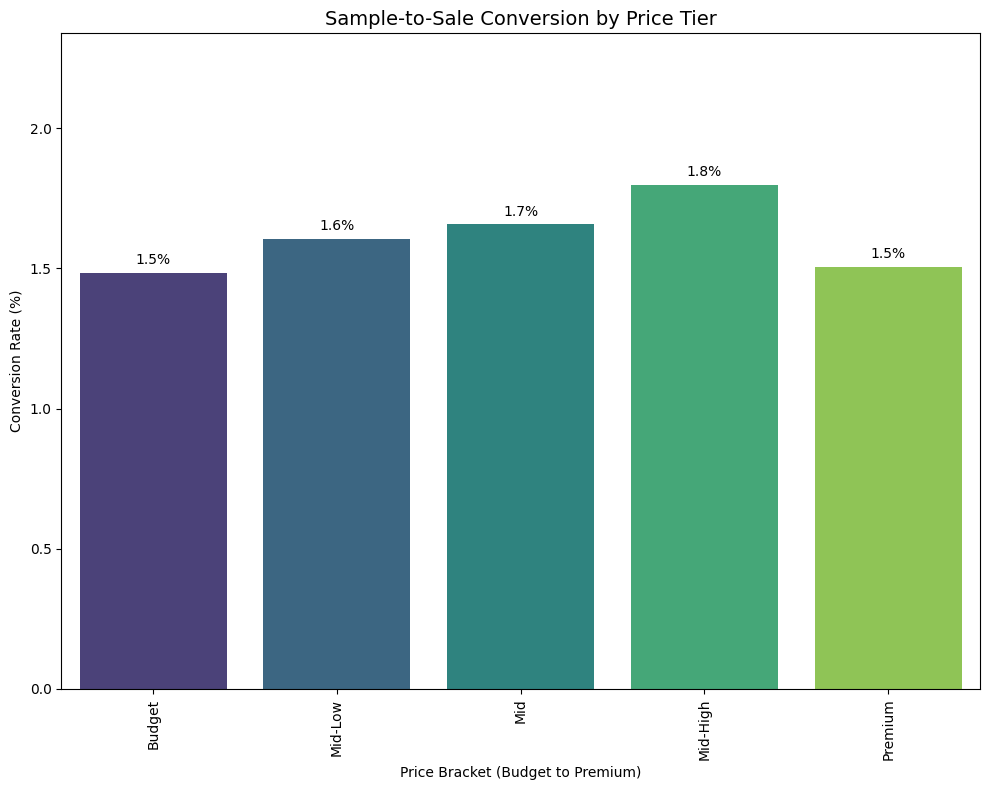

In [ ]:
df_prod['price_bin'] = pd.qcut(df_prod['price_usd'], q=5, 
                            labels=['Budget', 'Mid-Low', 'Mid', 'Mid-High', 'Premium'])

samples_with_price = df[df['type'] == 'SAMPLE'].merge(
    df_prod[['item_number', 'price_bin']], on='item_number', how='left'
)

converted_with_price = conversion_journey.merge(
    df_prod[['item_number', 'price_bin']], on='item_number', how='left'
)

#Calculated Conversion Rate per Tier
total_samples_per_bin = samples_with_price.groupby('price_bin').size()
converted_per_bin = converted_with_price.groupby('price_bin').size()

#final plotting dataframe
conversion_by_price = (converted_per_bin / total_samples_per_bin * 100).reset_index()
conversion_by_price.columns = ['price_bin', 'conv_rate']
conversion_by_price['conv_rate'] = conversion_by_price['conv_rate'].fillna(0) 

plt.figure(figsize=(10, 8)) 
ax = sns.barplot(data=conversion_by_price, x='price_bin', y='conv_rate', palette='viridis')

plt.xticks(rotation=90) 

for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 9), 
                textcoords='offset points')

plt.title('Sample-to-Sale Conversion by Price Tier', fontsize=14)
plt.ylabel('Conversion Rate (%)')
plt.xlabel('Price Bracket (Budget to Premium)')
plt.ylim(0, conversion_by_price['conv_rate'].max() * 1.3) 
plt.tight_layout()
plt.show()